
### Q1 (histogram of post and inference)

The *Gibbs sampler* in class for the prior $p(\theta,\tau) \propto 1$ was created by alternatingly sampling from the *full conditional* $p(\theta|\tau,\textbf{x})$ *normal* and  $p(\tau|\theta,\textbf{x})$ *gamma* distributions. Create this *Gibbs sampler* so your code can be used for the sample `x = stats.norm(loc=m, scale=s).rvs(size=n)` for any arbitrary `n`, `m`, and `s`.

*Use the code below or your own code to <u>provide a demonstration of Bayesian inference<u> for this data and model specification.*


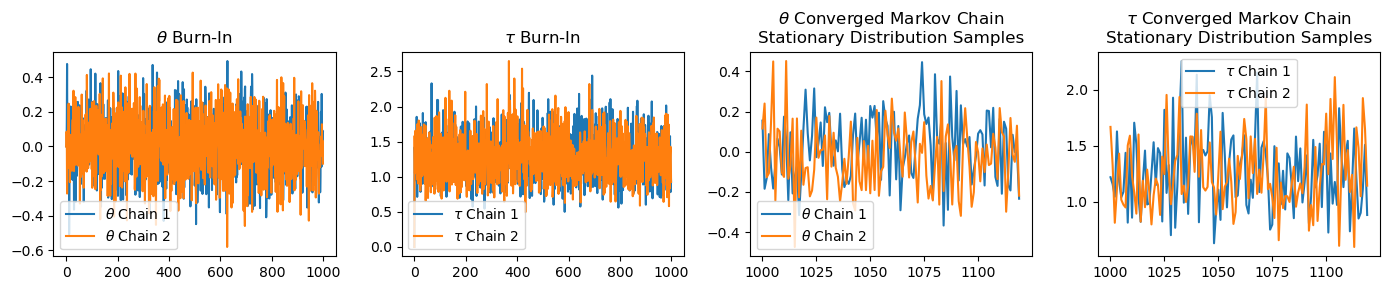

In [20]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Parameters
n = 30  # Number of data points
x = stats.norm(loc=0, scale=1).rvs(size=n)  # Simulated data
C, G = 2, 10000  # Chains and Gibbs samples
theta = np.zeros((C, G))  # Initialize theta
tau = np.zeros((C, G))  # Initialize tau

# Hyperparameters
mu0, tau0_sq = 0, 1  # For p(θ)
shape, rate = 2, 2   # For p(τ)

# Gibbs sampling
for c in range(C):
    for g in range(1, G):
        # Sample from p(τ | θ, x)
        shape_post = shape + n / 2
        scale_post = 1 / (rate + np.sum((x - theta[c, g - 1])**2) / 2)
        tau[c, g] = stats.gamma(a=shape_post, scale=scale_post).rvs()
        
        # Sample from p(θ | τ, x)
        tau_sq = 1 / tau[c, g]
        var_post = 1 / (n / tau_sq + 1 / tau0_sq)
        mean_post = var_post * (np.sum(x) / tau_sq + mu0 / tau0_sq)
        theta[c, g] = stats.norm(loc=mean_post, scale=np.sqrt(var_post)).rvs()

# Visualization of burn-in and stationary distributions
fig, ax = plt.subplots(1, 4, figsize=(14, 3))
ax[0].set_title("$\\theta$ Burn-In")
ax[1].set_title("$\\tau$ Burn-In")
ax[2].set_title("$\\theta$ Converged Markov Chain\nStationary Distribution Samples")
ax[3].set_title("$\\tau$ Converged Markov Chain\nStationary Distribution Samples")

# Burn-in and stationary distributions for θ and τ
demo = 120
for c in range(C):
    # Burn-in phase
    ax[0].plot(theta[c, :burn_in], label="$\\theta$ Chain " + str(c + 1))
    ax[1].plot(tau[c, :burn_in], label="$\\tau$ Chain " + str(c + 1))
    
    # Post burn-in (stationary samples)
    ax[2].plot(np.arange(burn_in, burn_in + demo, dtype=int), theta[c, burn_in:burn_in + demo], label="$\\theta$ Chain " + str(c + 1))
    ax[3].plot(np.arange(burn_in, burn_in + demo, dtype=int), tau[c, burn_in:burn_in + demo], label="$\\tau$ Chain " + str(c + 1))

# Add legends and display
for i in range(4):
    ax[i].legend()
plt.tight_layout()
plt.show()


95% credible interval for θ: [-0.42, 0.30]


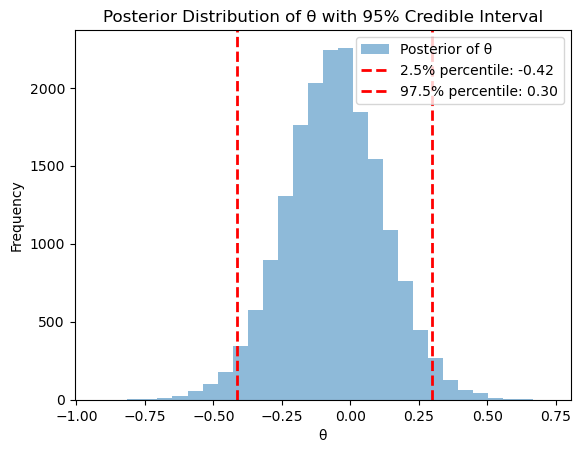

95% credible interval for τ: [0.61, 1.62]


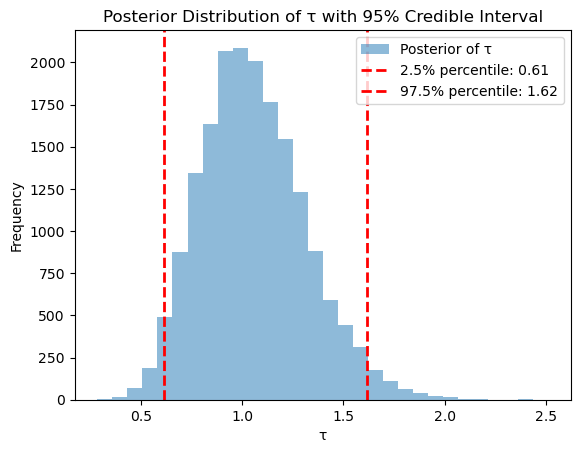

In [15]:
# Calculate the 95% credible interval for θ
theta_samples = theta[:, burn_in:].flatten()  # Flatten the posterior samples of θ
lower_bound = np.percentile(theta_samples, 2.5)  # Lower bound of the 95% credible interval
upper_bound = np.percentile(theta_samples, 97.5)  # Upper bound of the 95% credible interval

# Display the credible interval
print(f"95% credible interval for θ: [{lower_bound:.2f}, {upper_bound:.2f}]")

# Plot the posterior distribution of θ with the credible interval
plt.hist(theta_samples, bins=30, alpha=0.5, label="Posterior of θ")
plt.axvline(lower_bound, color='r', linestyle='dashed', linewidth=2, label=f"2.5% percentile: {lower_bound:.2f}")
plt.axvline(upper_bound, color='r', linestyle='dashed', linewidth=2, label=f"97.5% percentile: {upper_bound:.2f}")
plt.title("Posterior Distribution of θ with 95% Credible Interval")
plt.xlabel("θ")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Calculate the 95% credible interval for τ
tau_samples = tau[:, burn_in:].flatten()  # Flatten the posterior samples of τ
lower_bound_tau = np.percentile(tau_samples, 2.5)  # Lower bound of the 95% credible interval for τ
upper_bound_tau = np.percentile(tau_samples, 97.5)  # Upper bound of the 95% credible interval for τ

# Display the credible interval for τ
print(f"95% credible interval for τ: [{lower_bound_tau:.2f}, {upper_bound_tau:.2f}]")

# Optional: Plot the posterior distribution of τ with the credible interval
plt.hist(tau_samples, bins=30, alpha=0.5, label="Posterior of τ")
plt.axvline(lower_bound_tau, color='r', linestyle='dashed', linewidth=2, label=f"2.5% percentile: {lower_bound_tau:.2f}")
plt.axvline(upper_bound_tau, color='r', linestyle='dashed', linewidth=2, label=f"97.5% percentile: {upper_bound_tau:.2f}")
plt.title("Posterior Distribution of τ with 95% Credible Interval")
plt.xlabel("τ")
plt.ylabel("Frequency")
plt.legend()
plt.show()


### Q2 （inference,ans information in prior, and how effect post

Derive the *full conditional distributions* $p(\tau|\theta, \mathbf{x})$ and $p(\theta|\tau, \mathbf{x})$ if $p(\theta)$ is $N(\theta_0, \tau^2_0)$ and $p(\tau) \propto \tau^{\frac{\alpha}{2}-1} e^{- \frac{\lambda}{2} \tau}$. 

*Explain how to equate $\alpha$ and $\lambda$ with controlling the amount and nature of information the prior contributes to the posterior. How can we interpret these as controlling a "number of data points" contributed by the prior relative to the number of data points contributed to the posterior through the likelihoood?*

Create an updated version of the *Gibbs sampler* for $N(\theta_0, \tau^2_0)$ and $\textrm{gamma}(\textrm{shape}=\frac{\alpha}{2}, \textrm{rate}=\frac{\lambda}{2})$ priors for $p(\theta)$ and $p(\tau)$ respectively. 

*Demonstrate how changing the prior hyperparameters influences the posterior relative to the sample and the likelihood.*


---

\
\begin{align*}
p(\theta | \tau, \mathbf{x}) &\propto p(\mathbf{x} | \theta, \tau) p(\theta) \\
&\propto \prod_{i=1}^{n} \frac{1}{\sqrt{2\pi \tau^{-1}}} e^{-\frac{\tau}{2} (x_i - \theta)^2} \times \frac{1}{\sqrt{2\pi \tau_0^2}} e^{-\frac{1}{2\tau_0^2} (\theta - \theta_0)^2} \\
&\propto e^{-\frac{1}{2} \left[ \tau \sum_{i=1}^{n} (x_i - \theta)^2 + \frac{1}{\tau_0^2} (\theta - \theta_0)^2 \right]} \\
&\propto e^{-\frac{1}{2} \left[ \left( \tau n + \frac{1}{\tau_0^2} \right) \theta^2 - 2 \left( \tau n \bar{x} + \frac{\theta_0}{\tau_0^2} \right) \theta \right]} \\
&\propto e^{-\frac{1}{2\tau_n^2} (\theta - \theta_n)^2}
\end{align*}


where:
\
\begin{align*}
\tau_n^2 &= \frac{1}{\frac{n}{\tau} + \frac{1}{\tau_0^2}} \\
\theta_n &= \tau_n^2 \left( \frac{n\bar{x}}{\tau} + \frac{\theta_0}{\tau_0^2} \right)
\end{align*}


Thus,
\
\begin{align*}
p(\theta | \tau, \mathbf{x}) = \mathcal{N}(\theta_n, \tau_n^2)
\end{align*}

---

For the conditional of \tau:

\
\begin{align*}
p(\tau | \theta, \mathbf{x}) &\propto p(\mathbf{x} | \theta, \tau) p(\tau) \\
&\propto \tau^{n/2} e^{-\frac{\tau}{2} \sum_{i=1}^{n} (x_i - \theta)^2} \times \tau^{\alpha_2 - 1} e^{-\lambda_2 \tau} \\
&\propto \tau^{\alpha_2 + n/2 - 1} e^{-\tau \left( \lambda_2 + \frac{1}{2} \sum_{i=1}^{n} (x_i - \theta)^2 \right)}
\end{align*}


which is recognized as a Gamma distribution:
\
\begin{align*}
p(\tau | \theta, \mathbf{x}) = \text{Gamma}(\alpha_n, \lambda_n)
\end{align*}

where:

\
\begin{align*}
\alpha_n &= \alpha_2 + \frac{n}{2} \\
\lambda_n &= \lambda_2 + \frac{1}{2} \sum_{i=1}^{n} (x_i - \theta)^2
\end{align*}

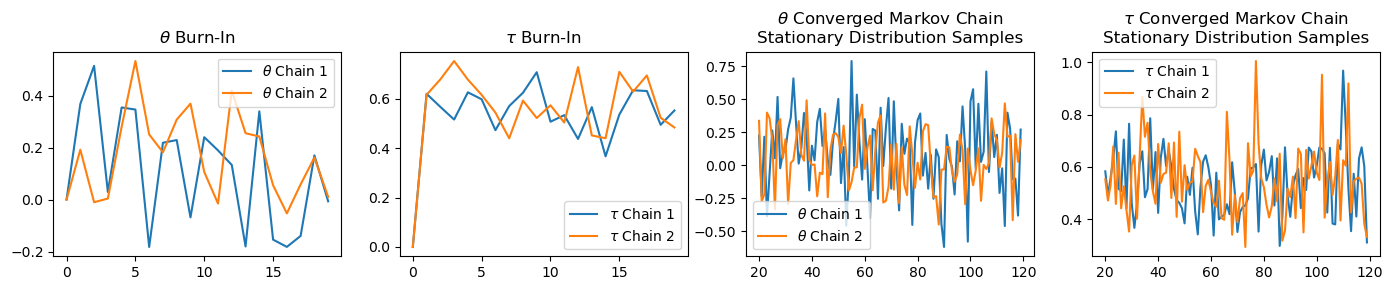

In [21]:
# Parameters
n, m, s = 30, 0, 1  # Data parameters
C, G = 2, 10000  # Number of chains and Gibbs samples
burn_in, demo = 20, 120  # Burn-in and visualization ranges
mu0 = 0  # Prior mean for θ

# Updated prior hyperparameters
tau0_sq_new = 0.5  # Smaller variance, stronger prior
shape_new, rate_new = 5, 10  # Stronger prior for τ

# Generate data
x = stats.norm(loc=m, scale=s).rvs(size=n)

# Initialize arrays for Gibbs sampling
theta_new = np.zeros((C, G))
tau_new = np.zeros((C, G))

# Gibbs Sampling with updated priors
for c in range(C):
    for g in range(1, G):
        # Sample from p(τ | θ, x) with updated priors
        shape_post = shape_new + n / 2
        scale_post = 1 / (rate_new + np.sum((x - theta_new[c, g - 1])**2) / 2)
        tau_new[c, g] = stats.gamma(a=shape_post, scale=scale_post).rvs()
        
        # Sample from p(θ | τ, x) with updated priors
        tau_sq = 1 / tau_new[c, g]
        var_post = 1 / (n / tau_sq + 1 / tau0_sq_new)
        mean_post = var_post * (np.sum(x) / tau_sq + mu0 / tau0_sq_new)
        theta_new[c, g] = stats.norm(loc=mean_post, scale=np.sqrt(var_post)).rvs()

# Visualization of Burn-In and Stationary Distributions
fig, ax = plt.subplots(1, 4, figsize=(14, 3))
ax[0].set_title("$\\theta$ Burn-In")
ax[1].set_title("$\\tau$ Burn-In")
ax[2].set_title("$\\theta$ Converged Markov Chain\nStationary Distribution Samples")
ax[3].set_title("$\\tau$ Converged Markov Chain\nStationary Distribution Samples")

for c in range(C):
    # Burn-in phase
    ax[0].plot(theta_new[c, :burn_in], label="$\\theta$ Chain " + str(c + 1))
    ax[1].plot(tau_new[c, :burn_in], label="$\\tau$ Chain " + str(c + 1))
    
    # Post burn-in (stationary samples)
    ax[2].plot(np.arange(burn_in, demo, dtype=int), theta_new[c, burn_in:demo], label="$\\theta$ Chain " + str(c + 1))
    ax[3].plot(np.arange(burn_in, demo, dtype=int), tau_new[c, burn_in:demo], label="$\\tau$ Chain " + str(c + 1))

for i in range(4):
    ax[i].legend()
plt.tight_layout()
plt.show()


95% credible interval for θ: [-0.46, 0.32]
95% credible interval for τ: [0.47, 1.15]


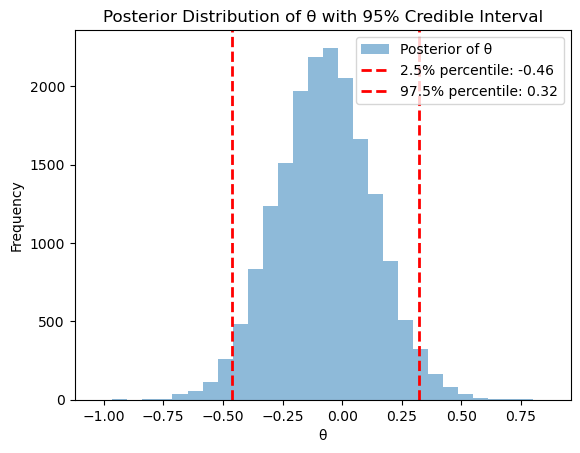

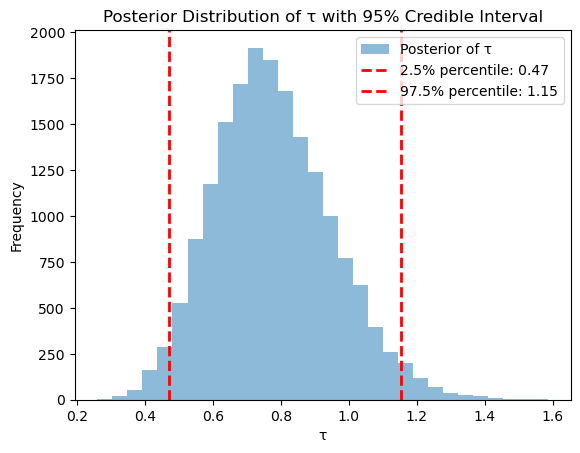

In [18]:
# Calculate the 95% credible interval for θ
theta_new_samples = theta_new[:, burn_in:].flatten()  # Flatten the posterior samples of θ
lower_bound_theta = np.percentile(theta_new_samples, 2.5)  # Lower bound of the 95% credible interval for θ
upper_bound_theta = np.percentile(theta_new_samples, 97.5)  # Upper bound of the 95% credible interval for θ

# Display the credible interval for θ
print(f"95% credible interval for θ: [{lower_bound_theta:.2f}, {upper_bound_theta:.2f}]")

# Calculate the 95% credible interval for τ
tau_new_samples = tau_new[:, burn_in:].flatten()  # Flatten the posterior samples of τ
lower_bound_tau = np.percentile(tau_new_samples, 2.5)  # Lower bound of the 95% credible interval for τ
upper_bound_tau = np.percentile(tau_new_samples, 97.5)  # Upper bound of the 95% credible interval for τ

# Display the credible interval for τ
print(f"95% credible interval for τ: [{lower_bound_tau:.2f}, {upper_bound_tau:.2f}]")

# Plot the posterior distribution of θ with the credible interval
plt.hist(theta_new_samples, bins=30, alpha=0.5, label="Posterior of θ")
plt.axvline(lower_bound_theta, color='r', linestyle='dashed', linewidth=2, label=f"2.5% percentile: {lower_bound_theta:.2f}")
plt.axvline(upper_bound_theta, color='r', linestyle='dashed', linewidth=2, label=f"97.5% percentile: {upper_bound_theta:.2f}")
plt.title("Posterior Distribution of θ with 95% Credible Interval")
plt.xlabel("θ")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Plot the posterior distribution of τ with the credible interval
plt.hist(tau_new_samples, bins=30, alpha=0.5, label="Posterior of τ")
plt.axvline(lower_bound_tau, color='r', linestyle='dashed', linewidth=2, label=f"2.5% percentile: {lower_bound_tau:.2f}")
plt.axvline(upper_bound_tau, color='r', linestyle='dashed', linewidth=2, label=f"97.5% percentile: {upper_bound_tau:.2f}")
plt.title("Posterior Distribution of τ with 95% Credible Interval")
plt.xlabel("τ")
plt.ylabel("Frequency")
plt.legend()
plt.show()



$\alpha$ controls the "strength" of the prior for $\tau$. Larger $\alpha$ corresponds to a higher prior confidence in $\tau$, influencing the posterior.

$\lambda$ adjusts how concentrated the prior is. Small $\lambda$ corresponds to a flatter prior, allowing the likelihood to dominate, while larger $\lambda$ provides more concentrated prior information.

These parameters effectively control how much weight the prior contributes relative to the data. Conceptually, the prior can be interpreted as contributing an equivalent "number of data points," with stronger priors influencing the posterior more significantly.

### Q3

(B) 
Let's dive deeper into **(B) Proportionality, Joint Identification, and Bayesian Sampling** with an example. We'll discuss:  

1. **Why Proportionality Matters in Bayesian Inference**  
2. **How Sampling Methods (e.g., MCMC) Help in Practice**  
3. **Python Code Example for Bayesian Inference using MCMC**  

---

## **1. Why Proportionality Matters in Bayesian Inference**
Bayes' theorem states:
\
\begin{align*}
p(\theta | x) = \frac{p(x | \theta) p(\theta)}{p(x)}
\end{align*}
- The denominator, $p(x)$, is just a **normalizing constant** that ensures the posterior integrates to 1.
- As long as we can recognize the functional form of the numerator$p(x | \theta) p(\theta)$, we can **identify the posterior distribution up to proportionality**.

For example, in a **Beta-Binomial** model:

\
\begin{align*}
p(\theta | x) \propto p(x | \theta) p(\theta)
\end{align*}

\begin{align*}
\propto \theta^{\sum x_i} (1-\theta)^{n - \sum x_i} \times \theta^{a-1} (1-\theta)^{b-1}
= \theta^{(a + \sum x_i - 1)} (1-\theta)^{(b + n - \sum x_i - 1)}
\end{align*}

Recognizing this as a **Beta distribution**, we directly conclude:

\begin{align*}
p(\theta | x) \sim \text{Beta}(a + \sum x_i, b + n - \sum x_i)
\end{align*}

This avoids needing to explicitly compute $p(x)$, making proportionality arguments a **powerful shortcut**.

---

## **2. Bayesian Inference with Sampling (MCMC)**
In complex models (non-conjugate priors, hierarchical models, high-dimensional problems), deriving an explicit posterior **is infeasible**. Instead, we use **sampling-based methods** like:

1. **Markov Chain Monte Carlo (MCMC)**  
   - Uses a **random walk** to explore the posterior distribution.
   - Examples: **Metropolis-Hastings, Gibbs Sampling, Hamiltonian Monte Carlo (HMC)**.

2. **Variational Inference (VI)**  
   - Approximates the posterior with a simpler distribution.
   - Computationally efficient but can be less accurate.

3. **Rejection Sampling**  
   - Directly samples from an easy-to-sample distribution and keeps values based on a probability threshold.

MCMC is one of the most widely used approaches. Let's see it in action.

## **3. Python Example: Bayesian Inference with MCMC**
We'll estimate the **posterior distribution of a coin's bias** $\theta$ given **Binomial likelihood** and a **Beta prior** using **PyMC3 (or PyMC)**.

### **Example Setup: Coin Flip Experiment**
- We flip a coin $n = 100$ times and observe $k = 60$ heads.
- Prior: $\theta \sim \text{Beta}(2,2)$ (moderate prior belief in fairness).
- Likelihood: $k \sim \text{Binomial}(n, \theta)$.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


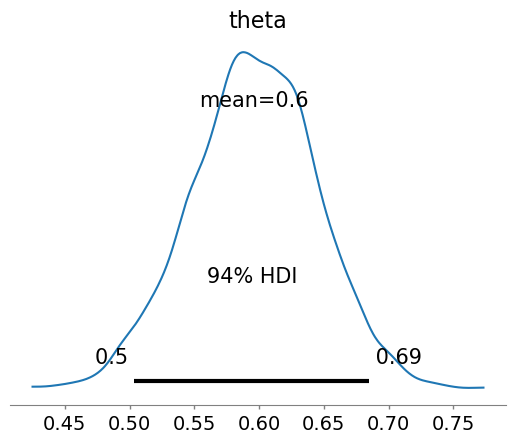

In [3]:
### **Code for Bayesian Inference using MCMC**

import pymc as pm
import numpy as np
import matplotlib.pyplot as plt

# Observed Data (60 heads in 100 flips)
n = 100
k = 60

# Bayesian Model
with pm.Model() as model:
    # Prior for θ (coin's bias)
    theta = pm.Beta("theta", alpha=2, beta=2)
    
    # Likelihood (Binomial)
    y = pm.Binomial("y", n=n, p=theta, observed=k)
    
    # MCMC Sampling
    trace = pm.sample(2000, return_inferencedata=True)

# Plot posterior distribution
pm.plot_posterior(trace)
plt.show()

## Key Takeaways from the Code: 
We define a Beta prior for 𝜃.
We define a Binomial likelihood for our observed data.
We use MCMC sampling (NUTS algorithm) to approximate the posterior.
The posterior plot gives a distribution over 𝜃 rather than a single estimate. 

---

## **4. Interpretation of Bayesian Inference**
Unlike classical statistics (which provides a single point estimate), Bayesian inference allows us to:
- **Compute credible intervals** (e.g., $ P(0.5 < \theta < 0.7 | X) $).
- **Visualize uncertainty** via posterior distributions.
- **Update beliefs with new data** seamlessly.

For example, after running the model, we might find:

\begin{align*}
P(0.55 < \theta < 0.65 | X) = 0.95
\end{align*}

This means **95% of the posterior mass is between 0.55 and 0.65**, giving us an intuitive probability-based interpretation.

---

## **Final Thoughts**
- **Proportionality lets us identify posteriors without solving integrals.**
- **In complex cases, MCMC lets us sample from the posterior instead of deriving it explicitly.**
- **Bayesian inference provides a full distribution over parameters, not just point estimates.**

This **trade-off**—from exact functional forms to **empirical sampling**—is what makes Bayesian methods both **practical and powerful** in real-world applications.